### Step 4: UV mapping $S_{ref}(x,y,z)$ into 2D using its spherical parameterization, $S_{\text{ref}}^{\Omega}(x,y,z)$

The spherical parameterization can be mapped into 2D, by using spherical coordinate transformations to get 1-1 correspondence enabling $S_\text{ref}(x,y,z)$ to be parameterized by 2D $(u,v)$ coordinate system, where $u$ and $v$ is the columns and rows of the 2D grid respectively. 

#### 1. Load $S_{ref}(x,y,z)$ and $S_{\text{ref}}^{\Omega}(x,y,z)$ meshes

We assume the user has worked through step 3 which generates and saves the equiareal parameterization $S_{\text{ref}}^{\mathcal{\Omega}}(x,y,z)$ of the genus-0 reference surface $S_{ref}(x,y,z)$ of an input cell surface mesh to the folder `example_results/bleb_example/step3_equiareal_sphere_param`. We also need the actual reference surface mesh from step 1 saved in the folder `example_results/bleb_example/step1_cMCF_reference`. Moreover these surface has been colored by curvature. 

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio

# example cell used
imgfolder = '../../data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step4_uv_mapping')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


# load the pre-computed genus-0 reference, S_ref(x,y,z)
S_ref_folder = 'example_results/%s/step1_cMCF_reference' %(basefname)
S_ref_file = os.path.join(S_ref_folder, 
                            'unwrap_cMCF_Sref_mesh_H_color.obj') 
S_ref_mesh = meshtools.read_mesh(S_ref_file)

# load the pre-computed genus-0 spherical parameterization of S_ref(x,y,z)
equiareal_folder = 'example_results/%s/step3_equiareal_sphere_param' %(basefname)
equiareal_file = os.path.join(equiareal_folder, 
                               'equiareal_sphere_param_Sref_%s.obj' %(basefname))
equiareal_sphere_mesh = meshtools.read_mesh(equiareal_file)

#### 2. Setting up the rectangular UV grid

The spherical parameterization is a mesh whose vertices do not correspond to the grid points of a rectangular grid after transforming to spherical coordinates with radius=1. 

Consequently, in order for every grid point of the UV grid to map to a point on the sphere, we need to resample the spherical parameterization at the points on the rectangular grid after transforming to their spherical coordinates with radius=1. This is called pullback.

In [2]:
import unwrap3D.Geometry.geometry as geometry

size = 256 # the larger the more hi-res but at the expense of computational cost and memory efficiency, 256 x 512 grid = 131,072 points already!

# set up a Nx2N uv grid by specifying the azimuthal and polar angles. 
# This aspect ratio is chosen to produce an isometric map that preserves the ratio of the arc length from north to south pole vs the equator arc length
ang_grid = geometry.img_2_angles(size, 2*size)  
unit_sphere_xyz = geometry.sphere_from_img_angles(ang_grid.reshape(-1,ang_grid.shape[-1]))
unit_sphere_xyz = unit_sphere_xyz.reshape((size,2*size,3))

We can visualise the grid to see how this 2D grid maps onto the standard unit sphere without foldover. We to this by uv texture mapping. Specifically we construct a 2D colormap from the top-left to the bottom-right of the uv grid and visualize this with the corresponding 3D (x,y,z) transformed coordinates. 

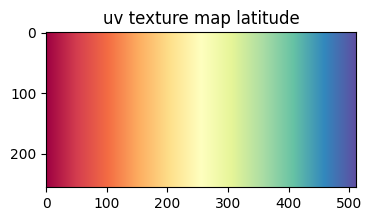

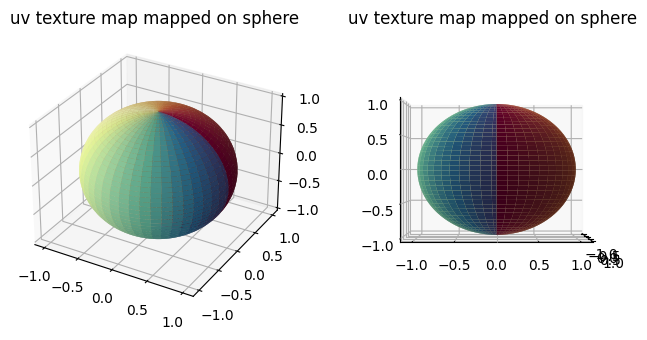

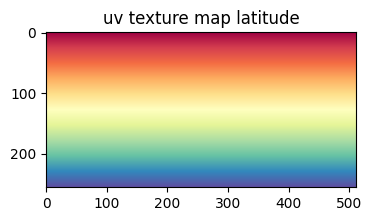

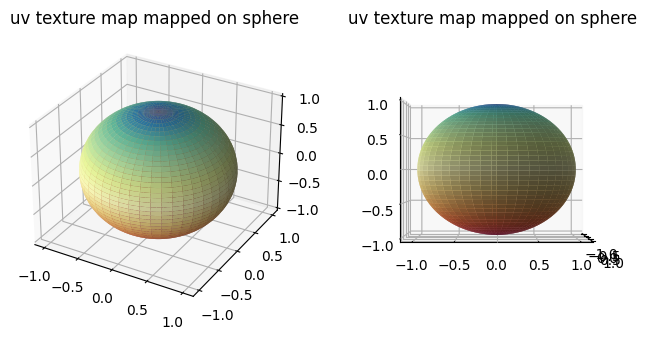

In [3]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm
import pylab as plt 

"""
1. Visualize the latitude lines first
"""
# colormap the uv grid with a continuous gradient colorscheme of the latitude lines 
unit_sphere_uv_labelgrid = np.arange(np.prod([size,2*size])).reshape(size,2*size, order='F') 
unit_sphere_uv_colormap = vol_colors.get_colors(unit_sphere_uv_labelgrid, colormap=cm.Spectral)

# visualize the uv texture colormap
plt.figure(figsize=(4,4))
plt.title('uv texture map latitude')
plt.imshow(unit_sphere_uv_colormap)
plt.show()

# visualize the uv texture colormap wrapped onto the coordinates specified by unit_sphere_xyz
fig = plt.figure(figsize=(4*2,4))
ax = fig.add_subplot(1,2,1,projection='3d')
plt.title('uv texture map mapped on sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('uv texture map mapped on sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)
ax.view_init(0,0)
plt.show()

"""
2. Visualize the longitude lines second
"""
# colormap the uv grid with a continuous gradient colorscheme of the latitude lines 
unit_sphere_uv_labelgrid = np.arange(np.prod([size,2*size])).reshape(size,2*size, order='C') 
unit_sphere_uv_colormap = vol_colors.get_colors(unit_sphere_uv_labelgrid, colormap=cm.Spectral)

# visualize the uv texture colormap
plt.figure(figsize=(4,4))
plt.title('uv texture map latitude')
plt.imshow(unit_sphere_uv_colormap)
plt.show()

# visualize the uv texture colormap wrapped onto the coordinates specified by unit_sphere_xyz
fig = plt.figure(figsize=(4*2,4))
ax = fig.add_subplot(1,2,1,projection='3d')
plt.title('uv texture map mapped on sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('uv texture map mapped on sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)
ax.view_init(0,0)
plt.show()


#### 3. Optimization of uv-unwrapping axis (optional, but *highly recommended*)

By default, the spherical grid as defined will uv-unwrap the spherical parameterization of $S_{ref}(x,y,z)$ in its native north-south axis i.e. the orientation the shape is when acquired. UV-unwrapping introduces greatest metric distortion at the poles. See this [animation](https://observablehq.com/@d3/orthographic-to-equirectangular) on the D3.js website. This is why areas on maps of the Earth do not reflect its actual geographical area! This can be undesirable for visualization or if it is desired to perform downstream analysis of the surface protrusions. Another reason is that unwrapping breaks the symmetry of the sphere. An unoptimal unwrapping axis may 'cut' through more protrusions than desired. Thus ideally all protrusions are unwrapped with minimal distortion with minimal cuts. 

u-Unwrap3D allows finding an optimal 'rotation' of $S_{ref}(x,y,z)$ through its spherical parameterization so that the desired surface features are mapped in the uv-unwrap with minimal distortion. The optimal rotation is found by solving a weighted eigendecomposition whereby the weighting is specified by the user to reflect the extent a vertex 'expresses' characteristics of the desired surface feature e.g. for surface protrusions weightings derived from curvature is a natural choice.  

We show two examples of this:

##### Example 1: Optimize unwrap for the curvature of $S_{\text{ref}}(x,y,z)$

The reference is non spherical and has two 'ends'. The blebs appear to concentrate at both of these ends, and present less elsewhere. We would like therefore to unwrap placing the two 'ends' equatorially in the uv-unwrap. We will: 

1. compute and use the absolute value of mean curvature of $S_{\text{ref}}(x,y,z)$ as vertex weights
2. apply weighted eigendecomposition to optimize the orientation of the spherical parameterization 

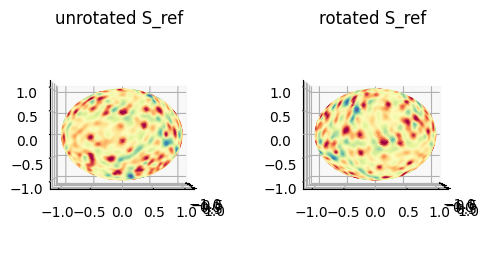

In [4]:
"""
Weight assignment - here we are going to use the absolute mean curvature of S_ref
"""
import igl
import numpy as np 

# Compute mean curvature of S_ref 
H_Sref = meshtools.compute_mean_curvature(S_ref_mesh, radius=5)

# define weights as the absolute value of curvature
weights = np.abs(H_Sref)
weights_proj = H_Sref # this is a signed i.e. has +/- values to resolve the ambiguity of putting the 

"""
Weighted Eigendecomposition to solve for the optimal rotation 
"""
rot_matrix, extra_rotate_bool = meshtools.optimize_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                weights=weights, 
                                                                                signed_weights_to_orient=weights_proj)

"""
Apply optimized rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot = meshtools.apply_optimized_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                    rot_matrix, 
                                                                                    extra_rotate_bool,
                                                                                    additional_rotation_angle_degrees=0)

"""
visualize the rotation
"""
import unwrap3D.Visualisation.plotting as plotting 
import pylab as plt 

sampling = 1

fig = plt.figure(figsize=(3*2,3))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('unrotated S_ref')
ax.scatter(equiareal_sphere_mesh.vertices[::sampling,2], 
           equiareal_sphere_mesh.vertices[::sampling,1],
           equiareal_sphere_mesh.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('rotated S_ref')
ax.scatter(equiareal_sphere_mesh_rot.vertices[::sampling,2], 
           equiareal_sphere_mesh_rot.vertices[::sampling,1],
           equiareal_sphere_mesh_rot.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plt.show()

##### Example 2: Optimize unwrap for the curvature of $S(x,y,z)$

The weights of Example 1 doesn't explicitly capture the curvature of the input surface. To explicitly capture we can instead use the mean curvature of $S(x,y,z)$ that has been transferred through matching of the cMCF and genus-0 $S_{\text{ref}}(x,y,z)$.

1. Use the absolute value of mean curvature of $S(x,y,z)$ transferred to the reference genus-0 $S_{\text{ref}}(x,y,z)$ as vertex weights
2. apply weighted eigendecomposition to optimize the orientation of the spherical parameterization 

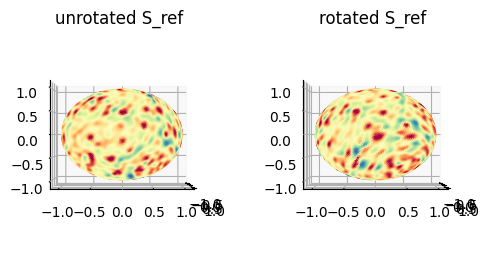

In [5]:
# Load the mean curvature of S(x,y,z) we previously transferred in Step 1
import scipy.io as spio 

curvature_stats_file = os.path.join(S_ref_folder, 
                            'unwrap_cMCF_remapped_surf_H.mat') 
curvature_stats_obj = spio.loadmat(curvature_stats_file)

H_S = np.squeeze(curvature_stats_obj['surf_H'])

# define weights as the absolute value of curvature
weights = np.abs(H_S)
weights_proj = H_S # this is a signed i.e. has +/- values to resolve the ambiguity of putting the 

"""
Weighted Eigendecomposition to solve for the optimal rotation 
"""
rot_matrix, extra_rotate_bool = meshtools.optimize_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                weights=weights, 
                                                                                signed_weights_to_orient=weights_proj)

"""
Apply optimized rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot_H_S = meshtools.apply_optimized_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                    rot_matrix, 
                                                                                    extra_rotate_bool,
                                                                                    additional_rotation_angle_degrees=0)

"""
visualize the rotation
"""
sampling = 1

fig = plt.figure(figsize=(3*2,3))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('unrotated S_ref')
ax.scatter(equiareal_sphere_mesh.vertices[::sampling,2], 
           equiareal_sphere_mesh.vertices[::sampling,1],
           equiareal_sphere_mesh.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('rotated S_ref')
ax.scatter(equiareal_sphere_mesh_rot_H_S.vertices[::sampling,2], 
           equiareal_sphere_mesh_rot_H_S.vertices[::sampling,1],
           equiareal_sphere_mesh_rot_H_S.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh_rot_H_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plt.show()

##### Example 3: Optimize unwrap for both curvature of $S(x,y,z)$ and $S_{\text{ref}}(x,y,z)$

- The weights of Example 1 doesn't explicitly capture the curvature of the input surface. 
- The weights of Example 2 doesn't explicitly capture the curvature of the reference surface.

In this example we will segment the positive protrusions on both input and reference and construct a weights using a weighted sum of the two binary segmentations to try to jointly account for the geometry of both.

To create the segmentation we choose a curvature threshold value 0.05

1. Combine the positive curvature protrusions of $S(x,y,z)$ and $S_{\text{ref}}(x,y,z)$ as vertex weights
2. apply weighted eigendecomposition to optimize the orientation of the spherical parameterization 

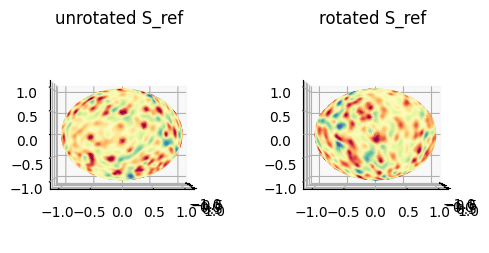

In [6]:
"""
Create weight from combining binary segmentation
"""
binary_H_Sref = H_Sref > 0.05
binary_H_S = H_S > 0.05

# define weights as the absolute value of curvature
weights = 0.5*binary_H_Sref+0.5*binary_H_S
weights_proj = weights.copy() # this is a signed i.e. has +/- values to resolve the ambiguity of putting the 

"""
Weighted Eigendecomposition to solve for the optimal rotation 
"""
rot_matrix, extra_rotate_bool = meshtools.optimize_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                weights=weights, 
                                                                                signed_weights_to_orient=weights_proj)

"""
Apply optimized rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot_combined = meshtools.apply_optimized_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                    rot_matrix, 
                                                                                    extra_rotate_bool,
                                                                                    additional_rotation_angle_degrees=0)

"""
visualize the rotation
"""
sampling = 1

fig = plt.figure(figsize=(3*2,3))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('unrotated S_ref')
ax.scatter(equiareal_sphere_mesh.vertices[::sampling,2], 
           equiareal_sphere_mesh.vertices[::sampling,1],
           equiareal_sphere_mesh.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('rotated S_ref')
ax.scatter(equiareal_sphere_mesh_rot_combined.vertices[::sampling,2], 
           equiareal_sphere_mesh_rot_combined.vertices[::sampling,1],
           equiareal_sphere_mesh_rot_combined.vertices[::sampling,0], 
           s=1,
           c=equiareal_sphere_mesh_rot_combined.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plt.show()

The effect of the rotation will be more apparent once we uv-unwrap. 

#### 4. UV-unwrapping with 'pullback'

To unwrap, we match the (unrotated or rotated) spherical parameterization to the uv grid we have showed how to set up. The coordinates of $S_{ref}(x,y,z)$ (or any other numerical quantity associated with the geometry) can then be mapped into the uv-space by barycentric interpolation.

u-Unwrap3D provides a single function call to setup the grid and to uv-unwrap the input spherical mesh. 

##### Example 1: uv-unwrap rotated spherical parameterization for the curvature of $S_{\text{ref}}(x,y,z)$
We map the rotated spherical parameterization, to unwrap $S_{\text{ref}}(x,y,z)$ and map the curvature colors for visualization.

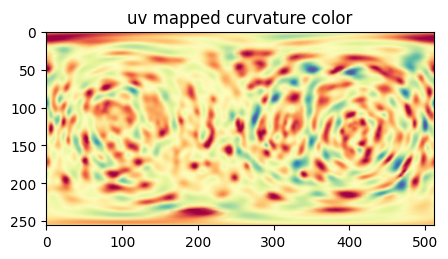

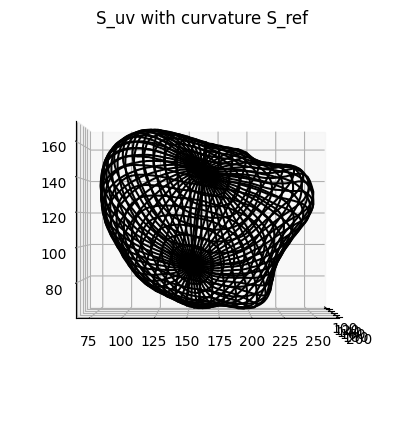

In [7]:
import unwrap3D.Unzipping.unzip as uzip

# this function sets up the uv grid internally and has options for optimizing its aspect ratio for geometry, i.e. not just N x 2N. 
# we did not have to setup the grid upfront. The above was to show how uv grid maps to the sphere.
S_uv_opt, uv_Sref_equiareal_match_rot, h_opt, H_color, uv_surface_measurements_labels = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot, 
                                                                                                                        surface_mesh=S_ref_mesh,
                                                                                                                        surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                        surface_measurements_labels=None,
                                                                                                                        uv_grid_size = 256, 
                                                                                                                        optimize_aspect_ratio=False, # Set true if you want to optimize the number of columns  
                                                                                                                        aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                        length_ratio_avg_fn=np.nanmedian,
                                                                                                                        h_opt=None)
H_color = np.uint8(H_color) # convert back to uint8 for visualization

plt.figure(figsize=(5,5))
plt.title('uv mapped curvature color')
plt.imshow(H_color)
plt.show()

# show the uv parameterization with wireframe.
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv with curvature S_ref')
ax.plot_wireframe(S_uv_opt[...,2], 
                  S_uv_opt[...,1], 
                  S_uv_opt[...,0], 
                  color='k',
                 rstride=10, cstride=10)
ax.view_init(0,0)
plt.show()

##### Example 2: uv-unwrap rotated spherical parameterization for the curvature of $S(x,y,z)$
We map the rotated spherical parameterization, to unwrap $S_{\text{ref}}(x,y,z)$ and map the curvature colors for visualization.

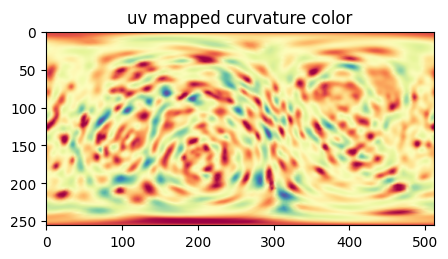

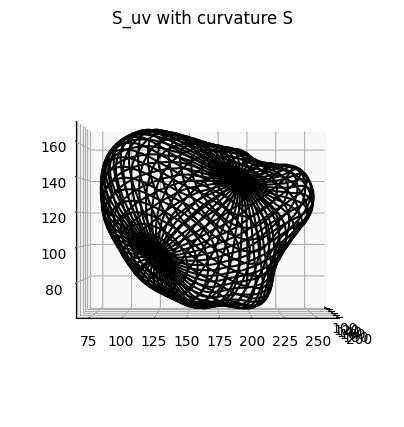

In [8]:
import unwrap3D.Unzipping.unzip as uzip

# this function sets up the uv grid internally and has options for optimizing its aspect ratio for geometry, i.e. not just N x 2N. 
# we did not have to setup the grid upfront. The above was to show how uv grid maps to the sphere.
S_uv_opt_H_S, uv_Sref_equiareal_match_rot_H_S, h_opt_H_S, H_color_H_S, uv_surface_measurements_labels_H_S = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_H_S, 
                                                                                                                        surface_mesh=S_ref_mesh,
                                                                                                                        surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                        surface_measurements_labels=None,
                                                                                                                        uv_grid_size = 256, 
                                                                                                                        optimize_aspect_ratio=False, # Set true if you want to optimize the number of columns  
                                                                                                                        aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                        length_ratio_avg_fn=np.nanmedian,
                                                                                                                        h_opt=None)
H_color_H_S = np.uint8(H_color_H_S) # convert back to uint8 for visualization

plt.figure(figsize=(5,5))
plt.title('uv mapped curvature color')
plt.imshow(H_color_H_S)
plt.show()

# show the uv parameterization with wireframe.
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv with curvature S')
ax.plot_wireframe(S_uv_opt_H_S[...,2], 
                  S_uv_opt_H_S[...,1], 
                  S_uv_opt_H_S[...,0], 
                  color='k',
                 rstride=10, cstride=10)
ax.view_init(0,0)
plt.show()

##### Example 3: uv-unwrap rotated spherical parameterization for the positive protrusions of $S(x,y,z)$ and $S_{\text{ref}}(x,y,z)$
We map the rotated spherical parameterization, to unwrap $S_{\text{ref}}(x,y,z)$ and map the curvature colors for visualization.

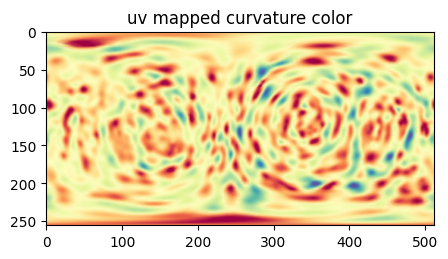

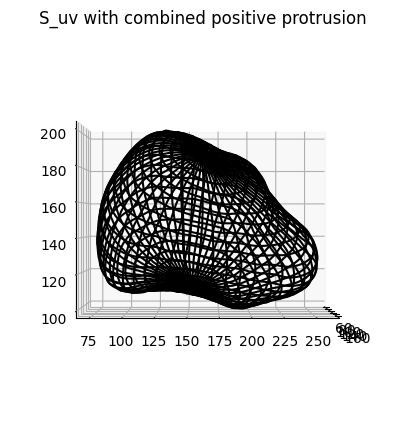

In [9]:
import unwrap3D.Unzipping.unzip as uzip

# this function sets up the uv grid internally and has options for optimizing its aspect ratio for geometry, i.e. not just N x 2N. 
# we did not have to setup the grid upfront. The above was to show how uv grid maps to the sphere.
S_uv_opt_combined, uv_Sref_equiareal_match_rot_combined, h_opt_combined, H_color_combined, uv_surface_measurements_labels_combined = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_combined, 
                                                                                                                        surface_mesh=S_ref_mesh,
                                                                                                                        surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                        surface_measurements_labels=None,
                                                                                                                        uv_grid_size = 256, 
                                                                                                                        optimize_aspect_ratio=False, # Set true if you want to optimize the number of columns  
                                                                                                                        aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                        length_ratio_avg_fn=np.nanmedian,
                                                                                                                        h_opt=None)
H_color_combined = np.uint8(H_color_combined) # convert back to uint8 for visualization

plt.figure(figsize=(5,5))
plt.title('uv mapped curvature color')
plt.imshow(H_color_combined)
plt.show()

# show the uv parameterization with wireframe.
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv with combined positive protrusion')
ax.plot_wireframe(S_uv_opt_combined[...,0], 
                  S_uv_opt_combined[...,1], 
                  S_uv_opt_combined[...,2], 
                  color='k',
                 rstride=10, cstride=10)
ax.view_init(0,0)
plt.show()


On a side note, a uv-parameterized surface can be easily visualized without a mesh viewer by matplotlib using the `plot_surface` function. 

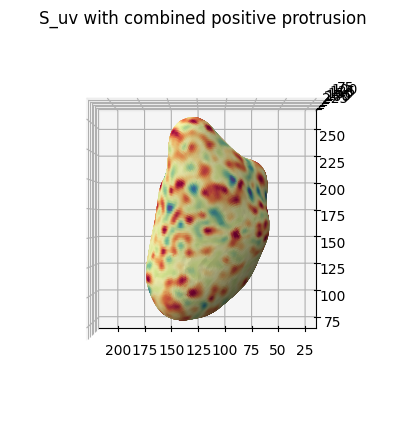

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv with combined positive protrusion')
ax.plot_surface(S_uv_opt_combined[...,0], 
                  S_uv_opt_combined[...,1], 
                  S_uv_opt_combined[...,2], 
                  facecolors=H_color_combined/255.,
                 rstride=2, cstride=2)
plotting.set_axes_equal(ax)
ax.view_init(-90,90)
plt.show()

#### 5. Comparing Examples 1,2,3
We can visualize the uv mapped curvature color side by side for better comparison

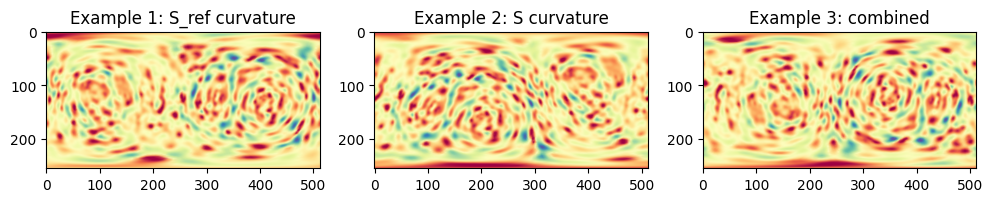

In [11]:
plt.figure(figsize=(4*3,4))
plt.subplot(131)
plt.title('Example 1: S_ref curvature')
plt.imshow(H_color)
plt.subplot(132)
plt.title('Example 2: S curvature')
plt.imshow(H_color_H_S)
plt.subplot(133)
plt.title('Example 3: combined')
plt.imshow(H_color_combined)
plt.show()

In [12]:
# save the uv mapped coordinates corresponding to the rotation of the combined (last version) to build topographic coordinates.
spio.savemat(os.path.join(savefolder, 
                          'uv_mapping_params.mat'),
             {'uv_map' : S_uv_opt_combined.astype(np.float32),
              'uv_mesh_match_tri_inds': uv_Sref_equiareal_match_rot_combined[0],
              'uv_mesh_match_barycenter_weights': uv_Sref_equiareal_match_rot_combined[1],
              'rot_matrix': rot_matrix, 
              'extra_rotate_bool': extra_rotate_bool,
              'S_ref_file': S_ref_file, 
              'equiareal_file': equiareal_file,
              'weights' : weights,
              'weights_proj': weights_proj})

import skimage.io as skio 
skio.imsave(os.path.join(savefolder,
                         'uv_H_color.tif'),
                         H_color_combined)

#### 6. User modifying the inferred optimal rotation

You can see currently from the uv-unwraps that the rotation optimization aims to place both 'ends' of $S_{\text{ref}}(x,y,z)$ in view. You might however after obtaining the result wish to put the 'end' with denser blebs into the center of the uv-unwrap.

We can adjust the inferred rotation by specifying an additional rotation `additional_rotation_angle_degrees` in degrees to the optimal rotation inference function `unwrap3D.Mesh.meshtools.apply_optimized_sphere_rotation_from_weights`. What this does is to effectively translate the uv-unwrap. The entire image columns represent $360^0$. Therefore doing $90^0$ means translating the image sideways to the right by 1/4 its columns size with periodic boundary conditions. We do this now for the combined objective of Example 3.

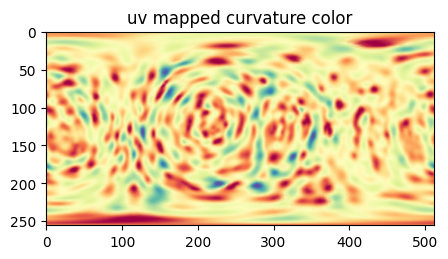

In [13]:
"""
Create weight from combining binary segmentation
"""
binary_H_Sref = H_Sref > 0.05
binary_H_S = H_S > 0.05

# define weights as the absolute value of curvature
weights = 0.5*binary_H_Sref+0.5*binary_H_S
weights_proj = weights.copy() # this is a signed i.e. has +/- values to resolve the ambiguity of putting the 

"""
Weighted Eigendecomposition to solve for the optimal rotation 
"""
rot_matrix, extra_rotate_bool = meshtools.optimize_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                weights=weights, 
                                                                                signed_weights_to_orient=weights_proj)

"""
Apply optimized rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot_combined = meshtools.apply_optimized_sphere_rotation_from_weights(equiareal_sphere_mesh, 
                                                                                    rot_matrix, 
                                                                                    extra_rotate_bool,
                                                                                    additional_rotation_angle_degrees=-90) # negative to translate left


"""
uv unwrap, the result should be the same as Example 3 but now translated to the left by 90 to emphasize the end with densest blebs more.
"""
S_uv_opt_combined, uv_Sref_equiareal_match_rot_combined, h_opt_combined, H_color_combined, uv_surface_measurements_labels_combined = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_combined, 
                                                                                                                        surface_mesh=S_ref_mesh,
                                                                                                                        surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                        surface_measurements_labels=None,
                                                                                                                        uv_grid_size = 256, 
                                                                                                                        optimize_aspect_ratio=False, # Set true if you want to optimize the number of columns  
                                                                                                                        aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                        length_ratio_avg_fn=np.nanmedian,
                                                                                                                        h_opt=None)
H_color_combined = np.uint8(H_color_combined) # convert back to uint8 for visualization

plt.figure(figsize=(5,5))
plt.title('uv mapped curvature color')
plt.imshow(H_color_combined)
plt.show()

#### 7. Optimizing the aspect ratio of the uv-unwrap

The default N x 2N uv unwrap is optimized for spherical shapes with this aspect ratio chosen based on the ratio between the arc lengths of the sphere from north-to-south pole to that of the equator. We can see for an elongated ellipsoid this aspect ratio will yield a distorted view, particularly if the major axis was mapped to the rows (i.e. v coordinate) and the minor axis was mapped to the columns (i.e. u coordinate) of the image. 

u-Unwrap3D allows auto-determination of the optimal aspect ratio by setting the `optimize_aspect_ratio=True` parameter in `unwrap3D.Unzipping.unzip.uv_map_sphere_surface_parameterization'

We implement two different optimization critera for aspect ratio:

1.  `aspect_ratio_method='length_ratio'`: This generalizes the arc length rationale for spheres and sets the aspect ratio based on the average total traversed length of $S_\text{ref}(x,y,z)$ along $v$-direction to that traversed along $u$-direction.
2. `aspect_ratio_method='beltrami'`: This optimizes for the [Beltrami coefficient](https://en.wikipedia.org/wiki/Beltrami_equation) which is related to finding [isothermal coordinates](https://en.wikipedia.org/wiki/Isothermal_coordinates) in differential geometry

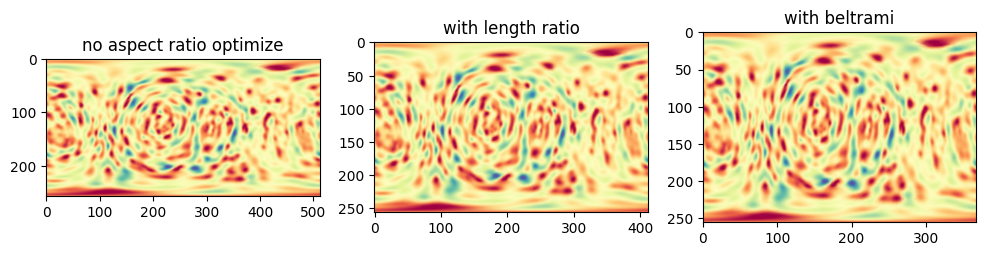

In [14]:
"""
1. aspect ratio with length ratio method with median as average function.
"""
S_uv_opt_combined_length_ratio, uv_Sref_equiareal_match_rot_combined_length_ratio, h_opt_combined_length_ratio, H_color_combined_length_ratio, uv_surface_measurements_labels_combined_length_ratio = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_combined, 
                                                                                                                                                                                                            surface_mesh=S_ref_mesh,
                                                                                                                                                                                                            surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                                                                                                            surface_measurements_labels=None,
                                                                                                                                                                                                            uv_grid_size = 256, 
                                                                                                                                                                                                            optimize_aspect_ratio=True, # Set true if you want to optimize the number of columns  
                                                                                                                                                                                                            aspect_ratio_method='length_ratio', # method for optimizing aspect ratio.
                                                                                                                                                                                                            length_ratio_avg_fn=np.nanmedian,
                                                                                                                                                                                                            h_opt=None)
H_color_combined_length_ratio = np.uint8(H_color_combined_length_ratio) # convert back to uint8 for visualization


"""
2. aspect ratio with beltrami method 
"""
S_uv_opt_combined_beltrami, uv_Sref_equiareal_match_rot_combined_beltrami, h_opt_combined_beltrami, H_color_combined_beltrami, uv_surface_measurements_labels_combined_beltrami = uzip.uv_map_sphere_surface_parameterization(sphere_mesh=equiareal_sphere_mesh_rot_combined, 
                                                                                                                                                                                                            surface_mesh=S_ref_mesh,
                                                                                                                                                                                                            surface_measurements_scalars=S_ref_mesh.visual.vertex_colors[:,:3]*1., # make sure its float.
                                                                                                                                                                                                            surface_measurements_labels=None,
                                                                                                                                                                                                            uv_grid_size = 256, 
                                                                                                                                                                                                            optimize_aspect_ratio=True, # Set true if you want to optimize the number of columns  
                                                                                                                                                                                                            aspect_ratio_method='beltrami', # method for optimizing aspect ratio.
                                                                                                                                                                                                            length_ratio_avg_fn=np.nanmedian,
                                                                                                                                                                                                            h_opt=None)
H_color_combined_beltrami = np.uint8(H_color_combined_beltrami) # convert back to uint8 for visualization



"""
Visualize all 3: no aspect ratio optimization, length_ratio and beltrami together
"""
plt.figure(figsize=(4*3,4))
plt.subplot(131)
plt.title('no aspect ratio optimize')
plt.imshow(H_color_combined)
plt.subplot(132)
plt.title('with length ratio')
plt.imshow(H_color_combined_length_ratio)
plt.subplot(133)
plt.title('with beltrami')
plt.imshow(H_color_combined_beltrami)
plt.show()